In [2]:
# import the nessessary packages
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import plotly.graph_objects as go
from models.ecoli.analysis import variantAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader

In [3]:
# work with the filterd data from saved_data_ng_internal_shift1: 
os.chdir(os.path.expanduser('~/wcEcoli/out/sherlock_data/saved_data_ng_internal_shift1/filtered_data/'))

# work specifically with the log data for the second sherlock run 
name_front = 'Filtered_AvgProteinCounts_Variant_'
name_back = '_startGen_14.csv'

# access the unfiltered protein counts too so that the total PC divisor can be calculated: 
unfiltered_pth = '~/wcEcoli/out/sherlock_data/saved_data_ng_internal_shift1/unfiltered_data/'
name_front_unfiltered = 'AvgProteinCounts_Variant_'

# load the varaint info:
variant_info = pd.read_excel('~/wcEcoli/out/sherlock_data/saved_data_ng_internal_shift1/sherlock_sim1_info.xlsx')
variant_info = pl.DataFrame(variant_info)

variant,NG expression,TE,viable sims,analysis sims,log(NG PCs +1)
i64,i64,f64,i64,i64,f64
0,0,0.0,96,40,0.0
1,7,5.0,95,39,5.101178
2,7,1.0,96,40,4.480199
3,7,0.1,96,40,3.456006
4,7,0.0,96,40,0.0
…,…,…,…,…,…
16,10,5.0,78,24,6.16788
17,10,1.0,92,36,5.571938
18,10,0.1,96,40,4.585958


In [29]:
# define a function that calculates the total protein count for each variant:
def get_total_protein_counts(var_num):
    # calculate the sum of all the protein counts for both the control and experimental variant (unfiltered):
    unfiltered_df = pd.read_csv(unfiltered_pth + name_front_unfiltered + str(var_num) + name_back)
    pl_unfiltered_df = pl.DataFrame(unfiltered_df)
    pl_unfiltered_df = pl_unfiltered_df.rename({pl_unfiltered_df.columns[1]: "Control_Variant", pl_unfiltered_df.columns[2]: "Experimental_Variant"}) 
    df_sum = pl_unfiltered_df.sum()
    
    # get the log10 of the total protein counts for the control and experimental variant:
    df_log10_Csum = df_sum["Control_Variant"].log10()
    df_log10_Esum = df_sum["Experimental_Variant"].log10()
    
    return df_sum["Control_Variant"].item(), df_sum["Experimental_Variant"].item(), df_log10_Csum.item(), df_log10_Esum.item()

# add a column to the variant info that contains the total protein counts for each variant:
total_PCs = [get_total_protein_counts(1)[0]]
for i in range(1, 21): 
    total_PCs.append(get_total_protein_counts(i)[1])
variant_info = variant_info.with_columns(pl.Series("total protein counts", total_PCs))
variant_info = variant_info.with_columns(pl.col("total protein counts").log10().alias("$log_{10}(total protein counts)"))
variant_info

[5172898.920241217, 5141931.105308643, 5417076.141113776, 5159561.115404759, 5188802.642281004, 4541374.593098468, 4176355.117404208, 5125410.8311395245, 5035365.244870417, 4846941.942050313, 4149881.548176994, 3929629.1182113593, 4760472.182557148, 5435517.218397701, 5268233.781681543, 3124268.6379001443, 3371015.0690465868, 4682804.717053452, 4894001.57085184, 4752919.991660369, 3056809.5277231634]


variant,NG expression,TE,viable sims,analysis sims,log(NG PCs +1),total protein counts,$log_{10}(total protein counts)
i64,i64,f64,i64,i64,f64,f64,f64
0,0,0.0,96,40,0.0,5.1729e6,6.713734
1,7,5.0,95,39,5.101178,5.1419e6,6.711126
2,7,1.0,96,40,4.480199,5.4171e6,6.733765
3,7,0.1,96,40,3.456006,5.1596e6,6.712613
4,7,0.0,96,40,0.0,5.1888e6,6.715067
…,…,…,…,…,…,…,…
16,10,5.0,78,24,6.16788,3.3710e6,6.527761
17,10,1.0,92,36,5.571938,4.6828e6,6.670506
18,10,0.1,96,40,4.585958,4.8940e6,6.689664


# Unfiltered Heatmpas

Text(0.5, 1.0, 'Variant Number')

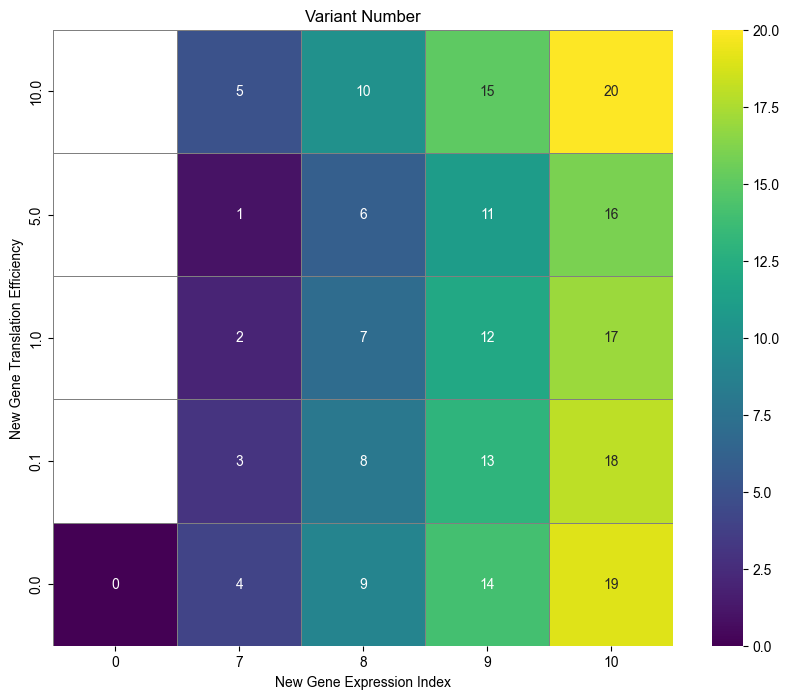

In [58]:
# make a heatmap of the variant numbers: 
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "variant"])
df = df.to_pandas()

heatmap_data = df.pivot(index='TE', columns='NG expression', values='variant')
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
# reverse the order of the y-axis:
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("Variant Number")


Text(0.5, 1.0, 'Analysis Sims for Each Variant')

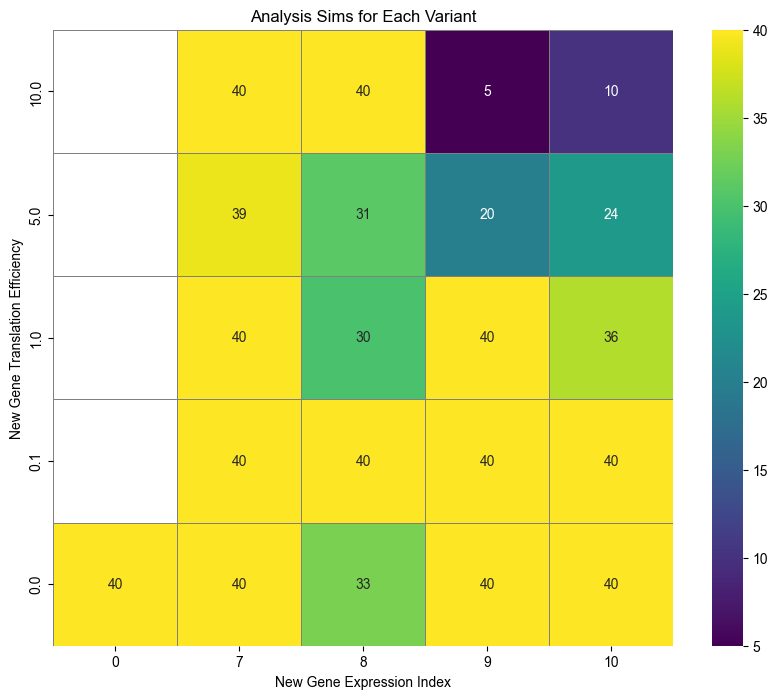

In [65]:
# make a heatmap of the total analysis sims used for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "analysis sims"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values='analysis sims')
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("Analysis Sims for Each Variant")

<Figure size 1000x800 with 0 Axes>

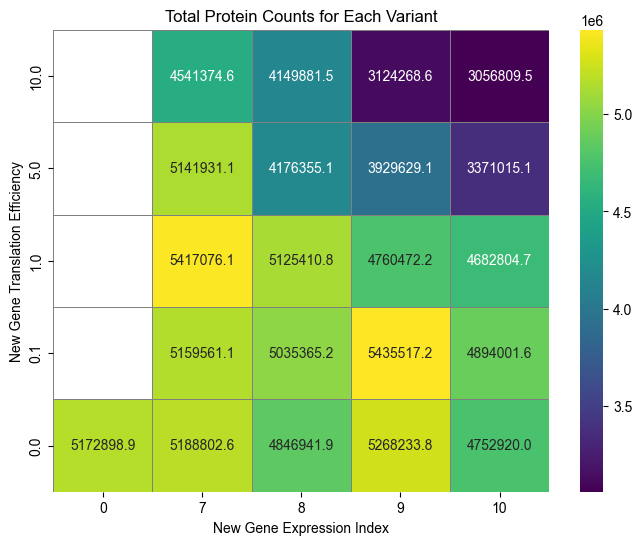

In [59]:
# make a heatmap of the total protein counts for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", 'total protein counts'])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values='total protein counts')
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()


# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("Total Protein Counts for Each Variant")

# Display the heatmap
plt.show()

<Figure size 1000x800 with 0 Axes>

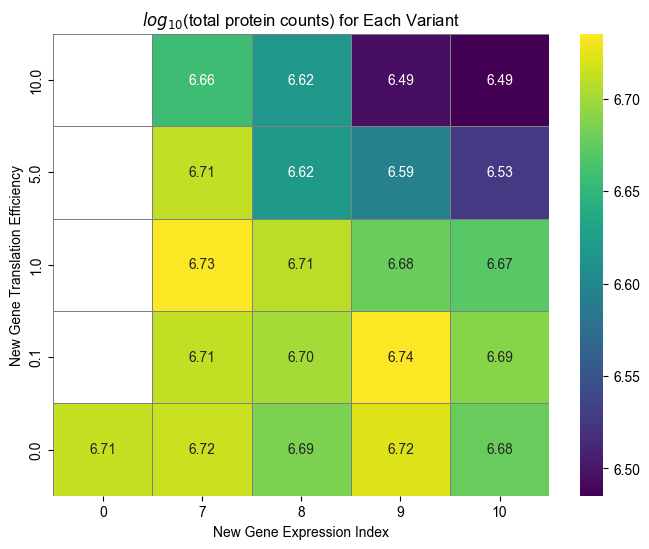

In [60]:
# make a heatmap of the log(total protein counts) for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "$log_{10}(total protein counts)"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values="$log_{10}(total protein counts)")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("$log_{10}$(total protein counts) for Each Variant")

# Display the heatmap
plt.show()

In [47]:
# find the max and min normalized protein count values for each variant: 
def get_max_min_log10normalized_protein_counts(var_num):
    
    # calculate the sum of all the protein counts for both the control and experimental variant (unfiltered):
    unfiltered_df = pd.read_csv(unfiltered_pth + name_front_unfiltered + str(var_num) + name_back)
    pl_unfiltered_df = pl.DataFrame(unfiltered_df)
    pl_unfiltered_df = pl_unfiltered_df.rename({pl_unfiltered_df.columns[1]: "Control_Variant", pl_unfiltered_df.columns[2]: "Experimental_Variant"}) 
    df_sum = pl_unfiltered_df.sum()
  
    # normalize the control data and take the log10 of the data (note: log10(protein_count_value) - log10(sum_over_all_protein_counts) = log10(protein_count_value/sum_over_all_protein_counts)):
    df_log10_C = pl_unfiltered_df.with_columns((pl.col("Control_Variant")+1).log10().alias("log10_Control_Variant"))
    df_log10_Csum = df_sum["Control_Variant"].log10()
    df_log10_C = df_log10_C.with_columns(pl.col("log10_Control_Variant") - df_log10_Csum)
    
    # normalize the experimental data and take the log10 of the data :
    df_log10_E = df_log10_C.with_columns((pl.col("Experimental_Variant")+1).log10().alias("log10_Experimental_Variant"))
    df_log10_Esum = df_sum["Experimental_Variant"].log10()
    df_log10_E = df_log10_E.with_columns(pl.col("log10_Experimental_Variant") - df_log10_Esum)
    
    # get the max and min values for the normalized protein counts:
    max_C = df_log10_C["log10_Control_Variant"].max()
    min_C = df_log10_C["log10_Control_Variant"].min()
    max_E = df_log10_E["log10_Experimental_Variant"].max()
    min_E = df_log10_E["log10_Experimental_Variant"].min()
    
    return max_C, min_C, max_E, min_E

def get_max_min_normalized_protein_counts(var_num):
    
    # calculate the sum of all the protein counts for both the control and experimental variant (unfiltered):
    unfiltered_df = pd.read_csv(unfiltered_pth + name_front_unfiltered + str(var_num) + name_back)
    pl_unfiltered_df = pl.DataFrame(unfiltered_df)
    pl_unfiltered_df = pl_unfiltered_df.rename({pl_unfiltered_df.columns[1]: "Control_Variant", pl_unfiltered_df.columns[2]: "Experimental_Variant"}) 
    df_sum = pl_unfiltered_df.sum()
  
    # normalize the control data and take the log10 of the data (note: log10(protein_count_value) - log10(sum_over_all_protein_counts) = log10(protein_count_value/sum_over_all_protein_counts)):
    df_C = pl_unfiltered_df.with_columns((pl.col("Control_Variant") / df_sum["Control_Variant"]).alias("normalized_Control_Variant"))
    
    # normalize the experimental data and take the log10 of the data :
    df_CE = df_C.with_columns((pl.col("Experimental_Variant") / df_sum["Experimental_Variant"]).alias("normalized_Experimental_Variant"))
    
    
    # get the max and min values for the normalized protein counts:
    max_C = df_CE["normalized_Control_Variant"].max()
    min_C = df_CE["normalized_Control_Variant"].min()
    max_E = df_CE["normalized_Experimental_Variant"].max()
    min_E = df_CE["normalized_Experimental_Variant"].min()
    
    return max_C, min_C, max_E, min_E


In [48]:
# heat map of the max and min values for the log10 normalized protein counts for each variant:
max_nums = [get_max_min_normalized_protein_counts(1)[0]]
min_nums = [get_max_min_normalized_protein_counts(1)[1]]
log_max_nums = [get_max_min_log10normalized_protein_counts(1)[0]]
log_min_nums = [get_max_min_log10normalized_protein_counts(1)[1]]

for i in range(1, 21):
    get_max_min_normalized_protein_counts(i)
    max_nums.append(get_max_min_normalized_protein_counts(i)[2])
    min_nums.append(get_max_min_normalized_protein_counts(i)[3])
    log_max_nums.append(get_max_min_log10normalized_protein_counts(i)[2])
    log_min_nums.append(get_max_min_log10normalized_protein_counts(i)[3])
    
# add the data to the variant info:
# add a column to the variant info that contains the total protein counts for each variant:

variant_info = variant_info.with_columns(pl.Series("max normalized PC", max_nums))
variant_info = variant_info.with_columns(pl.Series("min normalized PC", min_nums))
variant_info = variant_info.with_columns(pl.Series("max log10 normalized PC", log_max_nums))
variant_info = variant_info.with_columns(pl.Series("min log10 normalized PC", log_min_nums))
variant_info


variant,NG expression,TE,viable sims,analysis sims,log(NG PCs +1),total protein counts,$log_{10}(total protein counts),max normalized PC,min normalized PC,max log10 normalized PC,min log10 normalized PC
i64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64
0,0,0.0,96,40,0.0,5.1729e6,6.713734,0.045683,0.0,-1.340246,-6.713734
1,7,5.0,95,39,5.101178,5.1419e6,6.711126,0.045527,0.0,-1.341733,-6.711126
2,7,1.0,96,40,4.480199,5.4171e6,6.733765,0.047368,0.0,-1.324512,-6.733765
3,7,0.1,96,40,3.456006,5.1596e6,6.712613,0.046686,0.0,-1.330816,-6.712613
4,7,0.0,96,40,0.0,5.1888e6,6.715067,0.045851,0.0,-1.338648,-6.715067
…,…,…,…,…,…,…,…,…,…,…,…
16,10,5.0,78,24,6.16788,3.3710e6,6.527761,0.436635,0.0,-0.359881,-6.527761
17,10,1.0,92,36,5.571938,4.6828e6,6.670506,0.079695,0.0,-1.098568,-6.670506
18,10,0.1,96,40,4.585958,4.8940e6,6.689664,0.044114,0.0,-1.355418,-6.689664


<Figure size 1000x800 with 0 Axes>

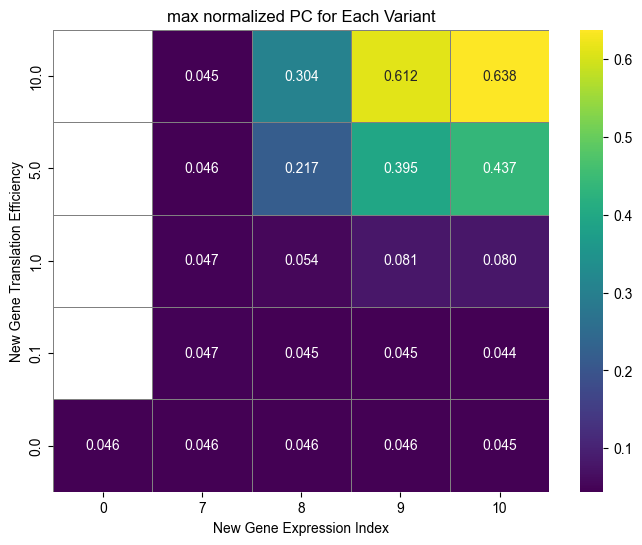

In [61]:
# make a heatmap of the log(total protein counts) for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "max normalized PC"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values="max normalized PC")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("max normalized PC for Each Variant")

# Display the heatmap
plt.show()

<Figure size 1000x800 with 0 Axes>

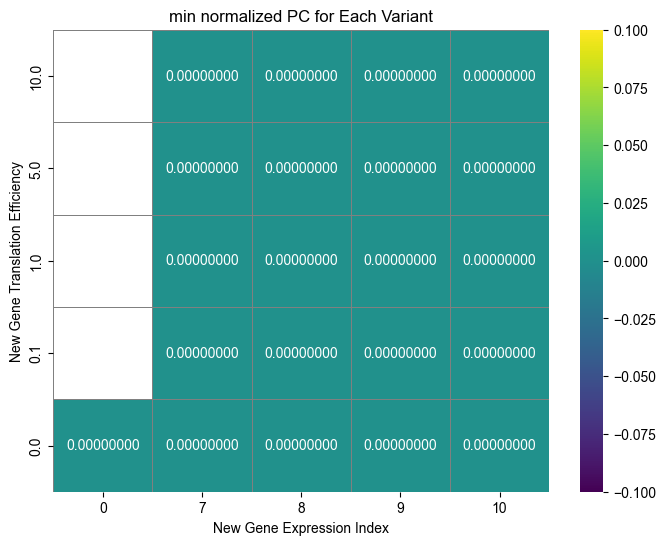

In [62]:
# make a heatmap of the log(total protein counts) for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "min normalized PC"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values="min normalized PC")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".8f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("min normalized PC for Each Variant")

# Display the heatmap
plt.show() # looks just as expected

Text(0.5, 1.0, 'max log10 normalized PC for Each Variant')

<Figure size 1000x800 with 0 Axes>

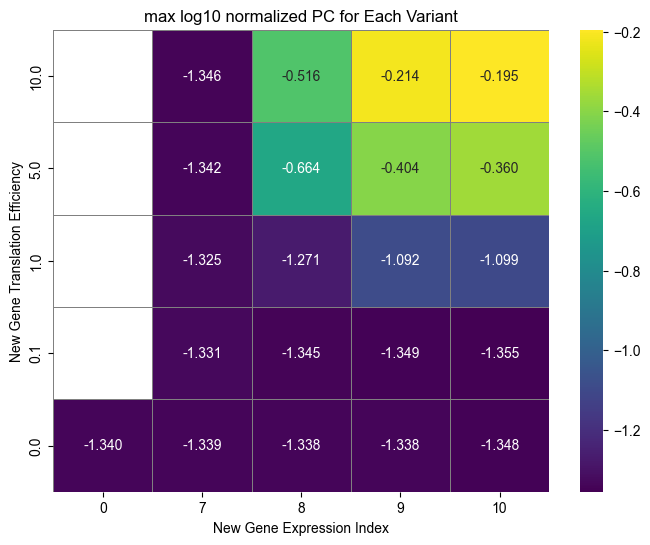

In [63]:
# log max plot

# make a heatmap of the log(total protein counts) for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "max log10 normalized PC"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values="max log10 normalized PC")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("max log10 normalized PC for Each Variant")

<Figure size 1000x800 with 0 Axes>

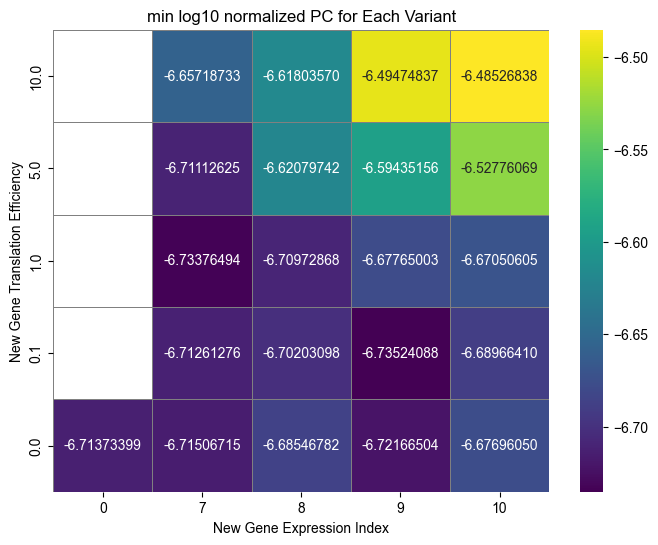

In [64]:
# make a heatmap of the log(total protein counts) for each variant: 
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "min log10 normalized PC"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values="min log10 normalized PC")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".8f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')    
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("min log10 normalized PC for Each Variant")

# Display the heatmap
plt.show() # is this as expeccted?

# Filtered data (PCs > 0)

In [66]:
# get the filtered mins and maxs: 
def get_max_min_filtered_log10normalized_protein_counts(var_num):
    # calculate the sum of all the protein counts for both the control and experimental variant (unfiltered):
    filtered_df = pd.read_csv(name_front + str(var_num) + name_back)
    pl_df = pl.DataFrame(filtered_df)
    pl_df = pl_df.rename({pl_df.columns[1]: "Control_Variant", pl_df.columns[2]: "Experimental_Variant"}) 
  
    CV_sum, EV_sum, CV_log_sum, EV_log_sum = get_total_protein_counts(var_num)
    
    # normalize the control data and take the log10 of the data (note: log10(protein_count_value) - log10(sum_over_all_protein_counts) = log10(protein_count_value/sum_over_all_protein_counts)):
    df_log10_C = pl_df.with_columns((pl.col("Control_Variant")).log10().alias("filtered_log10_Control_Variant"))
    df_log10_C = df_log10_C.with_columns(pl.col("filtered_log10_Control_Variant") - CV_log_sum)
    
    # normalize the experimental data and take the log10 of the data :
    df_log10_E = df_log10_C.with_columns((pl.col("Experimental_Variant")).log10().alias("filtered_log10_Experimental_Variant"))
    df_log10_E = df_log10_E.with_columns(pl.col("filtered_log10_Experimental_Variant") - EV_log_sum)
    
    # get the max and min values for the normalized protein counts:
    max_C = df_log10_C["filtered_log10_Control_Variant"].max()
    min_C = df_log10_C["filtered_log10_Control_Variant"].min()
    max_E = df_log10_E["filtered_log10_Experimental_Variant"].max()
    min_E = df_log10_E["filtered_log10_Experimental_Variant"].min()
    
    return max_C, min_C, max_E, min_E

def get_max_min_filtered_normalized_protein_counts(var_num):
    
    # calculate the sum of all the protein counts for both the control and experimental variant (unfiltered):
    filtered_df = pd.read_csv(name_front + str(var_num) + name_back)
    pl_df = pl.DataFrame(filtered_df)
    pl_df = pl_df.rename({pl_df.columns[1]: "Control_Variant", pl_df.columns[2]: "Experimental_Variant"}) 
  
    CV_sum, EV_sum, CV_log_sum, EV_log_sum = get_total_protein_counts(var_num)
  
    # normalize the control data:
    df_C = pl_df.with_columns((pl.col("Control_Variant") / CV_sum).alias("filtered_normalized_Control_Variant"))
    
    # normalize the experimental data data :
    df_CE = df_C.with_columns((pl.col("Experimental_Variant") / EV_sum).alias("filtered_normalized_Experimental_Variant"))
    
    
    # get the max and min values for the normalized protein counts:
    max_C = df_CE["filtered_normalized_Control_Variant"].max()
    min_C = df_CE["filtered_normalized_Control_Variant"].min()
    max_E = df_CE["get_max_min_filtered_log10normalized_protein_counts"].max()
    min_E = df_CE["get_max_min_filtered_log10normalized_protein_counts"].min()
    
    return max_C, min_C, max_E, min_E


In [67]:
# heat map of the max and min values for the log10 normalized protein counts for each variant:
max_nums = [get_max_min_filtered_normalized_protein_counts(1)[0]]
min_nums = [get_max_min_filtered_normalized_protein_counts(1)[1]]
log_max_nums = [get_max_min_filtered_normalized_protein_counts(1)[0]]
log_min_nums = [get_max_min_filtered_normalized_protein_counts(1)[1]]

for i in range(1, 21):
    get_max_min_normalized_protein_counts(i)
    max_nums.append(get_max_min_normalized_protein_counts(i)[2])
    min_nums.append(get_max_min_normalized_protein_counts(i)[3])
    log_max_nums.append(get_max_min_log10normalized_protein_counts(i)[2])
    log_min_nums.append(get_max_min_log10normalized_protein_counts(i)[3])
    
# add the data to the variant info:
# add a column to the variant info that contains the total protein counts for each variant:

variant_info = variant_info.with_columns(pl.Series("max filtered normalized PC", max_nums))
variant_info = variant_info.with_columns(pl.Series("min filtered normalized PC", min_nums))
variant_info = variant_info.with_columns(pl.Series("max filtered log10 normalized PC", log_max_nums))
variant_info = variant_info.with_columns(pl.Series("min filtered log10 normalized PC", log_min_nums))
variant_info


variant,NG expression,TE,viable sims,analysis sims,log(NG PCs +1),total protein counts,$log_{10}(total protein counts),max normalized PC,min normalized PC,max log10 normalized PC,min log10 normalized PC,max filtered normalized PC,min filtered normalized PC,max filtered log10 normalized PC,min filtered log10 normalized PC
i64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,0.0,96,40,0.0,5.1729e6,6.713734,0.045683,0.0,-1.340246,-6.713734,0.045683,2.1104e-9,0.045683,2.1104e-9
1,7,5.0,95,39,5.101178,5.1419e6,6.711126,0.045527,0.0,-1.341733,-6.711126,0.045527,0.0,-1.341733,-6.711126
2,7,1.0,96,40,4.480199,5.4171e6,6.733765,0.047368,0.0,-1.324512,-6.733765,0.047368,0.0,-1.324512,-6.733765
3,7,0.1,96,40,3.456006,5.1596e6,6.712613,0.046686,0.0,-1.330816,-6.712613,0.046686,0.0,-1.330816,-6.712613
4,7,0.0,96,40,0.0,5.1888e6,6.715067,0.045851,0.0,-1.338648,-6.715067,0.045851,0.0,-1.338648,-6.715067
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
16,10,5.0,78,24,6.16788,3.3710e6,6.527761,0.436635,0.0,-0.359881,-6.527761,0.436635,0.0,-0.359881,-6.527761
17,10,1.0,92,36,5.571938,4.6828e6,6.670506,0.079695,0.0,-1.098568,-6.670506,0.079695,0.0,-1.098568,-6.670506
18,10,0.1,96,40,4.585958,4.8940e6,6.689664,0.044114,0.0,-1.355418,-6.689664,0.044114,0.0,-1.355418,-6.689664


<Figure size 1000x800 with 0 Axes>

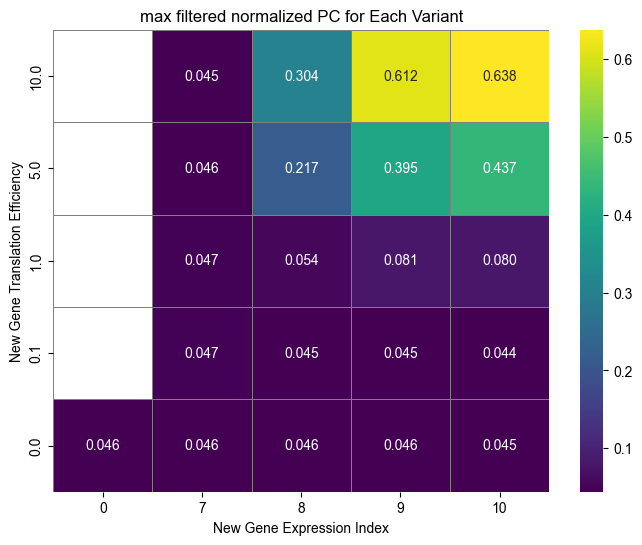

In [68]:
# make a heatmap of the log(total protein counts) for each variant:
plt.figure(figsize=(10, 8))

df = variant_info.select(["NG expression", "TE", "max filtered normalized PC"])
df = df.to_pandas()
heatmap_data = df.pivot(index='TE', columns='NG expression', values="max filtered normalized PC")
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar=True, linewidths=.5, linecolor='gray')
plt.gca().invert_yaxis()

# change the x and y labels:
plt.xlabel("New Gene Expression Index")
plt.ylabel("New Gene Translation Efficiency")
plt.title("max filtered normalized PC for Each Variant")

# Display the heatmap
plt.show()